# Time Series Forecasting Using LSTM Networks


**inspired by: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/**

In [56]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Import

In [4]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import numpy as np 
import pandas as pd 

import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

## Read the data

In [5]:
train = pd.read_csv('covid19_train.csv', parse_dates=[3], infer_datetime_format=True)
test = pd.read_csv('covid19_test.csv', parse_dates=[3], infer_datetime_format=True)

print("Train.shape", train.shape)
display(train.dtypes)
train.head()

Train.shape (35995, 6)


Id                         int64
Province_State            object
Country_Region            object
Date              datetime64[ns]
ConfirmedCases           float64
Fatalities               float64
dtype: object

Id Province_State Country_Region       Date  ConfirmedCases  Fatalities
0   1            NaN    Afghanistan 2020-01-22             0.0         0.0
1   2            NaN    Afghanistan 2020-01-23             0.0         0.0
2   3            NaN    Afghanistan 2020-01-24             0.0         0.0
3   4            NaN    Afghanistan 2020-01-25             0.0         0.0
4   5            NaN    Afghanistan 2020-01-26             0.0         0.0

In [6]:
print(train['Date'].min())
train['Days'] = train['Date']-train['Date'].min()
train.head()

2020-01-22 00:00:00


Id Province_State Country_Region       Date  ConfirmedCases  Fatalities  \
0   1            NaN    Afghanistan 2020-01-22             0.0         0.0   
1   2            NaN    Afghanistan 2020-01-23             0.0         0.0   
2   3            NaN    Afghanistan 2020-01-24             0.0         0.0   
3   4            NaN    Afghanistan 2020-01-25             0.0         0.0   
4   5            NaN    Afghanistan 2020-01-26             0.0         0.0   

    Days  
0 0 days  
1 1 days  
2 2 days  
3 3 days  
4 4 days

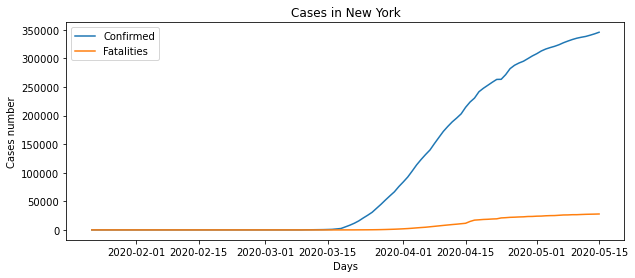

In [7]:
STATE = "New York"

df = train[train["Province_State"]==STATE]

plt.figure(figsize=(10, 4))

plt.plot(df["Date"], df['ConfirmedCases'], label='Confirmed')
plt.plot(df["Date"], df['Fatalities'], label='Fatalities')
plt.legend()
plt.title("Cases in "+STATE)
plt.ylabel("Cases number")
plt.xlabel("Days");

We will define the problem of supervised learning as the prediction of confirmed cases for a the following 10 days based on known cases in the previous 30 days.

In [8]:
confirmed=np.array(df['ConfirmedCases']).reshape(-1, 1)
fatalities=np.array(df['Fatalities']).reshape(-1, 1)


confirmed.shape, fatalities.shape

((115, 1), (115, 1))

## LSTM network for uni-variate time series

LSTM can be used to model univariate time series forecasting problems.

These problems consist of a single set of observations and a model is needed to learn from the past set of observations in order to forecast the next value in the sequence.

We will demonstrate a number of variations of the LSTM model for univariate time series forecasting.

Be careful not to draw hasty conclusions about the relative performance of the models. The number of layers or neurons are highly variable between models.

To do: time series where you want to predict, a sequence instead of a single value.

In [10]:
import math

SIZE = 100
n_features = 1 # for univariate time series

fct = lambda x: x*math.sin(x)
time_series = [fct(x) for x in range(SIZE)]


Consider a given univariate sequence:

`[10, 20, 30, 40, 50, 60, 70, 80, 90]`

We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned.

`X,				y
10, 20, 30		40
20, 30, 40		50
30, 40, 50		60
...`

The $\texttt{convert_data()}$ function below implements this behavior and will split a given univariate sequence into multiple samples where each sample has a specified number of time steps (`n_in, by default 3`) and the output has also a specified number of time steps (`n_out, by default 1`).

In [11]:
def convert_data_univariate(data, n_in=3, n_out=1):
    X, y = [], []
    # input sequence (t-n, ... t-1)
    for i in range(len(data)):
        # find the end of this pattern
        end_x = i + n_in
        end_y = end_x + n_out
        # check if we are beyond the sequence
        if end_y > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_x], data[end_x:end_y]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [12]:
# split into samples
n_in = 6
n_out = 1

X, y = convert_data_univariate(time_series, n_in, n_out)
# summarize the data
for i in range(4):
    print(X[i], y[i])
print("...")

[ 0.          0.84147098  1.81859485  0.42336002 -3.02720998 -4.79462137] [-1.67649299]
[ 0.84147098  1.81859485  0.42336002 -3.02720998 -4.79462137 -1.67649299] [4.59890619]
[ 1.81859485  0.42336002 -3.02720998 -4.79462137 -1.67649299  4.59890619] [7.91486597]
[ 0.42336002 -3.02720998 -4.79462137 -1.67649299  4.59890619  7.91486597] [3.70906637]
...


In [13]:
testAndValid = 0.1
SPLIT = int(testAndValid*len(X))

### Vanilla LSTM

The form of the input for each sample is specified in the input_shape argument on the definition of the first hidden layer. The model expects the input component for training data to have the dimensions or shape : `[samples, timesteps, features]` here.


In [14]:
# reshape from [samples, timesteps] into [samples, n_in, n_features]
X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

In [15]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, LSTM, Bidirectional, AveragePooling1D
from keras import utils

LSTM_SIZE = 16

inputs = Input(shape=(n_in, n_features))
outputs = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(inputs)
predictions = Dense(n_out, activation='linear')(outputs)

In [16]:
def build_and_fit(inputs, outputs, X_train, y_train, X_test, y_test):
    # This creates a model that includes
    # the Input layer and three Dense layers
    model = Model(inputs=inputs, outputs=predictions)

    # print the network
    utils.print_summary(model)

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    es = EarlyStopping(monitor="val_loss", mode="min", patience=10)
    mc = ModelCheckpoint("model.h5", monitor="val_mae", mode="min", save_best_only=True)
    callbacks = [es, mc]


    history = model.fit(X_train[:-SPLIT], y_train[:-SPLIT], epochs=200,
                        validation_data=[X_train[-SPLIT:], y_train[-SPLIT:]],
                        callbacks=callbacks, verbose=0, shuffle=False)
    model = load_model("model.h5")
    y_pred = model.predict(X_test)
    
    # plot history
    plt.figure(figsize=(20,5))

    if len(y_train.shape)==2:
        plt.subplot(331)
        plt.plot(history.history['loss'][3:], label='loss')
        plt.plot(history.history['val_loss'][3:], label='val_loss')
        plt.legend()
    
        plt.subplot(332)
        plt.plot(history.history['mae'][3:], label='mae')
        plt.plot(history.history['val_mae'][3:], label='val_mae')
        plt.legend()
    
        plt.subplot(333)
        plt.plot(range(len(y_train)), y_train, label="train")
        plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test, label="test")
        plt.plot(range(len(y_train), len(y_train)+len(y_pred)), y_pred, label="predict")
        plt.legend(loc='center left')
    else:
        # plot history
        subplot=str(y_pred.shape[1]+2)+str(y_pred.shape[1]+2)
        
        plt.subplot(subplot+"1")
        plt.plot(history.history['loss'][3:], label='loss')
        plt.plot(history.history['val_loss'][3:], label='val_loss')
        plt.legend()
    
        plt.subplot(subplot+"2")
        plt.plot(history.history['mae'][3:], label='mae')
        plt.plot(history.history['val_mae'][3:], label='val_mae')
        plt.legend()
    
        for i in range(y_pred.shape[1]):
            plt.subplot(subplot+str(i+3))
            plt.plot(range(len(y_train)), y_train[:,i,:], label="train"+str(i))
            plt.plot(range(len(y_train), len(y_train)+len(y_test)), y_test[:,i,:], label="test"+str(i))
            plt.plot(range(len(y_train), len(y_train)+len(y_pred)), y_pred[:,i,:], label="predict"+str(i))
            plt.legend(loc='center left')

    plt.show()
    
    return model

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 6, 1)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                1152      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,169
Trainable params: 1,169
Non-trainable params: 0
_________________________________________________________________


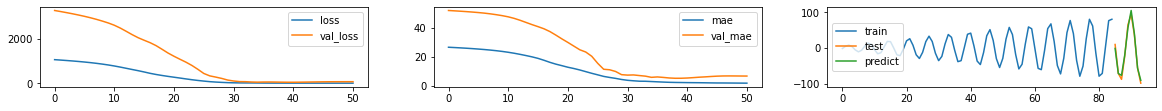

In [17]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [18]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start, start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-9.398598]] 324


### Stacked Bi-LSTM

In order to improve the performance of the model, it's possible to:
- stack LSTM with `return_sequence=Tru` for all levels except the last one where `return_sequence=False`
- use Bi-LSTM

In [19]:
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 6, 1)              0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 6, 32)             2304      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 6, 32)             6272      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 14,881
Trainable params: 14,881
Non-trainable params: 0
_________________________________________________________________


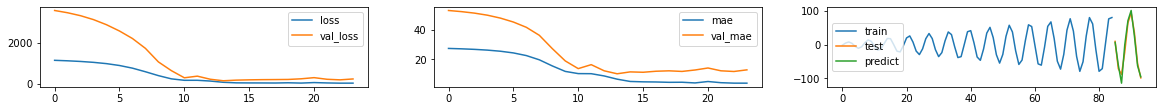

In [20]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [21]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-6.3936653]] 324


### Other kind of network

#### CNN-LSTM

A CNN model can be used in a hybrid model with an LSTM backend where the CNN is used to interpret subsequences of input that together are provided as a sequence to an LSTM model to interpret.

The first step is to split the input sequences into subsequences that can be processed by the CNN model. For example, we can first split our univariate time series data into input/output samples with four steps as input and one as output. Each sample can then be split into two sub-samples, each with two time steps. The CNN can interpret each subsequence of two time steps and provide a time series of interpretations of the subsequences to the LSTM model to process as input.

We can parameterize this and define the number of subsequences as n_seq and the number of time steps per subsequence as n_steps. The input data can then be reshaped to have the required structure: `[samples, subsequences, timesteps, features]`.

`n_step` is the number of time steps per subsequence.

In [22]:
# reshape from [samples, timesteps] into [samples, subsequences, n_steps, n_features]
n_seq = 2 # subsequence size
if n_in % n_seq == 0:
    n_steps = n_in // n_seq
else:
    print("bad subsequence value")
    stop()
X_train = X.reshape((X.shape[0], n_seq, n_steps, n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], n_seq, n_steps, n_features))[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

In [23]:
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

CNN_SIZE = 16

inputs = Input(shape=(n_seq, n_steps, n_features))
outputs = TimeDistributed(Conv1D(filters=CNN_SIZE, kernel_size=1, activation='relu'))(inputs)
outputs = TimeDistributed(MaxPooling1D(pool_size=2))(outputs)
outputs = TimeDistributed(Flatten())(outputs)
outputs = TimeDistributed(Flatten())(outputs)
outputs = LSTM(50, activation='relu')(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2, 3, 1)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 2, 3, 16)          32        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 2, 1, 16)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 2, 16)             0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 2, 16)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                13400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51  

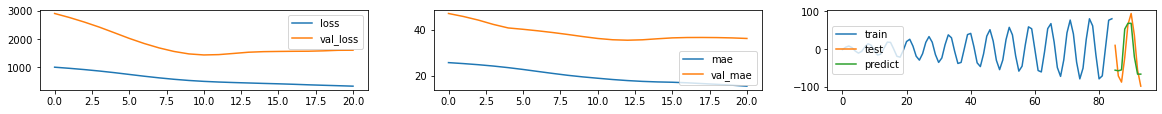

In [24]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [25]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-1.7730737]] 324


#### ConvLSTM

A type of LSTM related to the CNN-LSTM is the ConvLSTM, where the convolutional reading of input is built directly into each LSTM unit.

The ConvLSTM was developed for reading two-dimensional spatial-temporal data, but can be adapted for use with univariate time series forecasting.

The layer expects input as a sequence of two-dimensional images, therefore the shape of input data must be: `[samples, timesteps, rows, columns, features]`.

For our purposes, we can split each sample into subsequences where timesteps will become the number of subsequences, or n_seq, and columns will be the number of time steps for each subsequence, or n_steps. The number of rows is fixed at 1 as we are working with one-dimensional data.

In [26]:
# reshape from [samples, timesteps] into [samples, subsequences, n_steps, n_features]
n_seq = 2 # subsequence size
if n_in % n_seq == 0:
    n_steps = n_in // n_seq
else:
    print("bad subsequence value")
    stop()
X_train = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

In [27]:
from keras.layers import ConvLSTM2D

CNN_SIZE = 16

inputs = Input(shape=(n_seq, 1, n_steps, n_features))
outputs = ConvLSTM2D(filters=CNN_SIZE, kernel_size=(1,n_steps), activation='relu')(inputs)
outputs = Flatten()(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 2, 1, 3, 1)        0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 1, 1, 16)          3328      
_________________________________________________________________
flatten_3 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 3,345
Trainable params: 3,345
Non-trainable params: 0
_________________________________________________________________


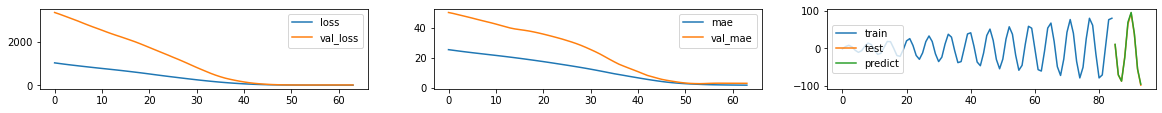

In [28]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

In [29]:
# demonstrate prediction
start = 12
y_true = (start+n_in)*(start+n_in)
x_input = np.array([fct(x) for x in range(start,start+n_in)])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_out))
yhat = model.predict(x_input, verbose=0)
print(yhat, y_true)

[[-8.310931]] 324


## LSTM network for multi-variate time series 

Multivariate time series data means data where there is more than one observation for each time step.

There are two main models that we may require with multivariate time series data; they are:

* Multiple Input Series.
* Multiple Parallel Series.

Let’s take a look at each in turn.

### Multiple Input Series

In [30]:
fct2 = lambda x: 2*x

time_series1 = np.array([fct(x) for x in range(SIZE)])
time_series2 = np.array([fct2(x) for x in range(SIZE)])
out_seq = np.array([time_series1[i]+time_series2[i] for i in range(SIZE)])

We can reshape these three arrays of data as a single dataset where each row is a time step, and each column is a separate time series. This is a standard way of storing parallel time series in a CSV file.

In [31]:
# convert to [rows, columns] structure
time_series1 = time_series1.reshape((len(time_series1), 1))
time_series2 = time_series2.reshape((len(time_series2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((time_series1, time_series2, out_seq))
dataset[:5]

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.84147098,  2.        ,  2.84147098],
       [ 1.81859485,  4.        ,  5.81859485],
       [ 0.42336002,  6.        ,  6.42336002],
       [-3.02720998,  8.        ,  4.97279002]])

As with the univariate time series, we must structure these data into samples with input and output elements.

An LSTM model needs sufficient context to learn a mapping from an input sequence to an output value. LSTMs can support parallel input time series as separate variables or features. Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.

If we chose three input time steps, then the first sample would look as follows:

Input:

`0,  0
1,  2
4,  4`

Output: `8`


In [32]:
# split a multivariate sequence into samples
def convert_data_multipleinputseries(data, n_in=3, n_out=1):
    X, y = [], []
    # input sequence (t-n, ... t-1)
    for i in range(len(data)):
        # find the end of this pattern
        end_x = i + n_in
        end_y = end_x + n_out
        # check if we are beyond the sequence
        if end_y > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_x, :-1], data[end_x:end_y, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [33]:
n_in = 6
n_out = 1

X, y = convert_data_multipleinputseries(dataset, n_in, n_out)
# summarize the data
for i in range(3):
    print(X[i], y[i])
print("...")

n_features = X.shape[-1] # in order to capture the multi-variate dimension

[[ 0.          0.        ]
 [ 0.84147098  2.        ]
 [ 1.81859485  4.        ]
 [ 0.42336002  6.        ]
 [-3.02720998  8.        ]
 [-4.79462137 10.        ]] [10.32350701]
[[ 0.84147098  2.        ]
 [ 1.81859485  4.        ]
 [ 0.42336002  6.        ]
 [-3.02720998  8.        ]
 [-4.79462137 10.        ]
 [-1.67649299 12.        ]] [18.59890619]
[[ 1.81859485  4.        ]
 [ 0.42336002  6.        ]
 [-3.02720998  8.        ]
 [-4.79462137 10.        ]
 [-1.67649299 12.        ]
 [ 4.59890619 14.        ]] [23.91486597]
...


Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional, CNN, or ConvLSTM model.

We will use a Vanilla LSTM where the number of time steps and parallel series (features) are specified for the input layer via the input_shape argument.

In [34]:
inputs = Input(shape=(n_in, n_features))
outputs = LSTM(LSTM_SIZE, return_sequences=False, activation='relu')(inputs)
predictions = Dense(n_out, activation='linear')(outputs)

In [35]:
X_train.shape, X_test.shape

((85, 2, 1, 3, 1), (9, 2, 1, 3, 1))

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 6, 2)              0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                1216      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________


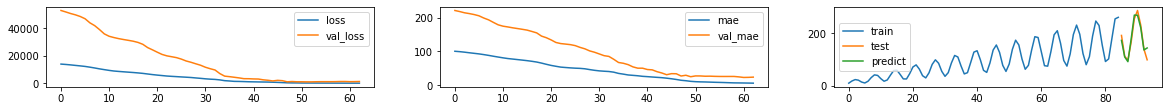

In [36]:
X_train = X[:-SPLIT]
X_test = X[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

### Multiple Parallel Series

An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each.

For example, given the data from the previous section:

`[ 0,  0,  0]
[ 1,  2,  3]
[ 4,  4,  8]
[ 9,  6, 15]`

We may want to predict the value for each of the three time series for the next time step.This might be referred to as multivariate forecasting. Again, the data must be split into input/output samples in order to train a model. The first sample of this dataset would be:

Input:

`0,  0,  0
1,  2,  3
4,  4,  8`

Output:

`9,  6, 15`

In [37]:
# split a multivariate sequence into samples
def convert_data_multiplesparallelseries(data, n_in=3, n_out=1):
    X, y = [], []
    # input sequence (t-n, ... t-1)
    for i in range(len(data)):
        # find the end of this pattern
        end_x = i + n_in
        end_y = end_x + n_out
        # check if we are beyond the sequence
        if end_y > len(data):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_x, :], data[end_x:end_y, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [38]:
n_in = 6
n_out = 1

X, y = convert_data_multiplesparallelseries(dataset, n_in, n_out)
if n_out==1:
    y = y.reshape(y.shape[0], y.shape[-1])
# summarize the data
for i in range(3):
    print(X[i], y[i])
print("...")

n_features = X.shape[-1] # in order to capture the multi-variate dimension


[[ 0.          0.          0.        ]
 [ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]] [-1.67649299 12.         10.32350701]
[[ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]] [ 4.59890619 14.         18.59890619]
[[ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]
 [ 4.59890619 14.         18.59890619]] [ 7.91486597 16.         23.91486597]
...


Any of the varieties of LSTMs in the previous section can be used, such as a Vanilla, Stacked, Bidirectional, CNN, or ConvLSTM model.

We will use a Stacked Bi-LSTM where the number of time steps and parallel series (features) are specified for the input layer via the input_shape argument. The number of parallel series is also used in the specification of the number of values to predict by the model in the output layer; again, this is three.

In [39]:
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_features, activation='linear')(outputs)

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 6, 3)              0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 6, 32)             2560      
_________________________________________________________________
bidirectional_5 (Bidirection (None, 6, 32)             6272      
_________________________________________________________________
bidirectional_6 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 99        
Total params: 15,203
Trainable params: 15,203
Non-trainable params: 0
_________________________________________________________________


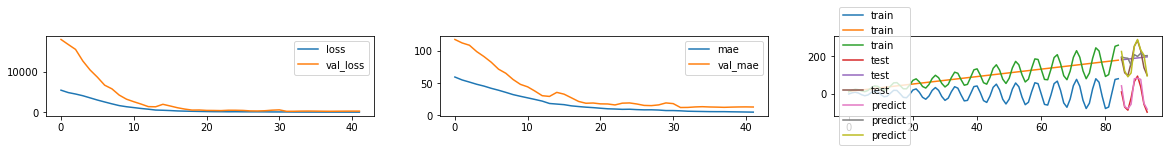

In [40]:
X_train = X[:-SPLIT]
X_test = X[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

## Multi-step LSTM Models

A time series forecasting problem that requires a prediction of multiple time steps into the future can be referred to as multi-step time series forecasting. Specifically, these are problems where the forecast horizon or interval is more than one time step. There are two main types of LSTM models that can be used for multi-step forecasting; they are:

1. Vector Output Model
1. Encoder-Decoder Model

In [41]:
time_series = [fct(x) for x in range(SIZE)]

n_in = 3
n_out = 2
X, y = convert_data_univariate(time_series, n_in, n_out)

# summarize the data
for i in range(3):
    print(X[i], y[i])
...

[0.         0.84147098 1.81859485] [ 0.42336002 -3.02720998]
[0.84147098 1.81859485 0.42336002] [-3.02720998 -4.79462137]
[ 1.81859485  0.42336002 -3.02720998] [-4.79462137 -1.67649299]


Ellipsis

### Vector-output model

Like other types of neural network models, the LSTM can output a vector directly that can be interpreted as a multi-step forecast. This approach was seen in the previous section were one time step of each output time series was forecasted as a vector.

As with the LSTMs for univariate data in a prior section, the prepared samples must first be reshaped. The LSTM expects data to have a three-dimensional structure of [samples, timesteps, features], and in this case, we only have one feature so the reshape is straightforward.

In [42]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1 # stand for uni-variate time series

X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

y_train = y[:-SPLIT]
y_test = y[-SPLIT:]

Any of the presented Bi-LSTM model types could be used, such as Vanilla, Stacked, Bidirectional, CNN-LSTM, or ConvLSTM. Below defines a Stacked LSTM for multi-step forecasting.

In [43]:
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)
predictions = Dense(n_out, activation='linear')(outputs)

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 3, 32)             2304      
_________________________________________________________________
bidirectional_8 (Bidirection (None, 3, 32)             6272      
_________________________________________________________________
bidirectional_9 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 66        
Total params: 14,914
Trainable params: 14,914
Non-trainable params: 0
_________________________________________________________________


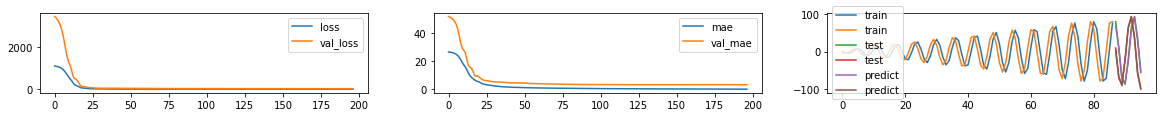

In [44]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

### Encoder-Decoder Model
It's a model specifically developed for forecasting variable length output sequence. The model was designed for prediction problems where there are both input and output sequences, so-called sequence-to-sequence, or seq2seq problems, such as translating text from one language to another.

As its name suggests, the model is comprised of two sub-models: the encoder and the decoder.

The encoder is a model responsible for reading and interpreting the input sequence. The output of the encoder is a fixed length vector that represents the model’s interpretation of the sequence. The encoder is traditionally a Vanilla LSTM model, although other encoder models can be used such as Stacked, Bidirectional, and CNN models.

In [45]:
n_features = 1 # stand for uni-variate time series

In [46]:
# Encoder part
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
encoded = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)

The decoder uses the output of the encoder as an input.

* First, the fixed-length output of the encoder is repeated, once for each required time step in the output sequence.
* Then, this sequence is then provided to an LSTM decoder model. The model must output a value for each value in the output time step, which can be interpreted by a single output model.
* Then, we can use the same output layer or layers to make each one-step prediction in the output sequence. This can be achieved by wrapping the output part of the model in a TimeDistributed wrapper.

In [47]:
# Decoder part
from keras.layers import RepeatVector

outputs = RepeatVector(n_out)(encoded)
outputs = LSTM(LSTM_SIZE, activation='relu', return_sequences=True)(outputs)
predictions = TimeDistributed(Dense(1))(outputs)

In [48]:
# reshape input data from [samples, timesteps] into [samples, timesteps, features]
X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

# reshape output data from [samples, timesteps] into [samples, timesteps, features]
y_train = y.reshape((y.shape[0], y.shape[1], n_features))[:-SPLIT]
y_test = y.reshape((y.shape[0], y.shape[1], n_features))[-SPLIT:]

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3, 1)              0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 3, 32)             2304      
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 3, 32)             6272      
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 32)                6272      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 32)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 2, 16)             3136      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 2, 1)              17  

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


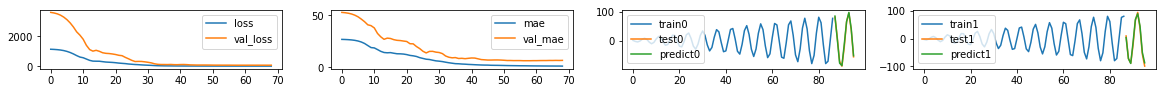

In [49]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)

### Multiple Parallel Input and Multi-Step Output

A problem with parallel time series may require the prediction of multiple time steps of each time series.

In [50]:
n_in = 6
n_out = 2

X, y = convert_data_multiplesparallelseries(dataset, n_in, n_out)
n_features = X.shape[-1] # in order to capture the multi-variate dimension

# summarize the data
for i in range(3):
    print("-"*15)
    print("X:", X[i])
    print("y:", y[i])

---------------
X: [[ 0.          0.          0.        ]
 [ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]]
y: [[-1.67649299 12.         10.32350701]
 [ 4.59890619 14.         18.59890619]]
---------------
X: [[ 0.84147098  2.          2.84147098]
 [ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]]
y: [[ 4.59890619 14.         18.59890619]
 [ 7.91486597 16.         23.91486597]]
---------------
X: [[ 1.81859485  4.          5.81859485]
 [ 0.42336002  6.          6.42336002]
 [-3.02720998  8.          4.97279002]
 [-4.79462137 10.          5.20537863]
 [-1.67649299 12.         10.32350701]
 [ 4.59890619 14.         18.59890619]]
y: [[ 7.91486597 16.         23.91486597]
 [ 3.70906637 18.         21.709

We can use either the Vector Output or Encoder-Decoder LSTM to model this problem. In this case, we will use the Encoder-Decoder model.

In [51]:
# Encoder part
inputs = Input(shape=(n_in, n_features))
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(inputs)
outputs = Bidirectional(LSTM(LSTM_SIZE, return_sequences=True, activation='relu'))(outputs)
encoded = Bidirectional(LSTM(LSTM_SIZE, return_sequences=False, activation='relu'))(outputs)

In [52]:
# Decoder part
from keras.layers import RepeatVector

outputs = RepeatVector(n_out)(encoded)
outputs = LSTM(LSTM_SIZE, activation='relu', return_sequences=True)(outputs)
predictions = TimeDistributed(Dense(n_features))(outputs)

In [53]:
# reshape input data from [samples, timesteps] into [samples, timesteps, features]
X_train = X.reshape((X.shape[0], X.shape[1], n_features))[:-SPLIT]
X_test = X.reshape((X.shape[0], X.shape[1], n_features))[-SPLIT:]

# reshape output data from [samples, timesteps] into [samples, timesteps, features]
y_train = y.reshape((y.shape[0], y.shape[1], n_features))[:-SPLIT]
y_test = y.reshape((y.shape[0], y.shape[1], n_features))[-SPLIT:]

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 6, 3)              0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 6, 32)             2560      
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 6, 32)             6272      
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 32)                6272      
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 2, 32)             0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 2, 16)             3136      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 2, 3)              51  

/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:50: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:56: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


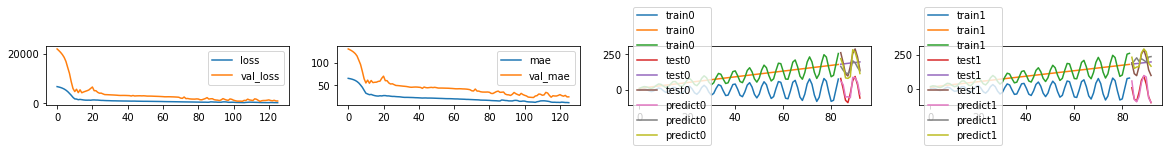

In [54]:
model = build_and_fit(inputs, predictions, X_train, y_train, X_test, y_test)